In [1]:
import numpy as np   
import pandas as pd   
import os 
import tensorflow as tf 
import string
from keras.preprocessing.sequence import pad_sequences 
from keras.preprocessing.text import Tokenizer 
from keras.models import Model 
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation 
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add 
from keras.utils import to_categorical, plot_model 
from keras.applications.inception_v3 import InceptionV3, preprocess_input 
import matplotlib.pyplot as plt  # for plotting data 
from pickle import load,dump

In [2]:
def load_description(text): 
    mapping = dict()
    for line in text.split("\n"): 
        token = line.split("\t") 
        if len(line) < 2:   # remove short descriptions 
            continue
        img_id = token[0].split('.')[0] # name of the image 
        img_description = token[1]      # description of the image
        if img_id not in mapping: 
            mapping[img_id] = list() 
        mapping[img_id].append(img_description)
    return mapping 
  
#token_path = 'data/Flickr8k_text/Flickr8k.lemma.token.txt' # Lemmatized tokens
token_path = 'data/Flickr8k_text/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read() 
descriptions = load_description(text) 
print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress be climb up a set of stair in an entry way .', 'A girl go into a wooden building .', 'A little girl climb into a wooden playhouse .', 'A little girl climb the stair to her playhouse .', 'A little girl in a pink dress go into a wooden cabin .']


In [3]:
def clean_description(desc): 
    for key, des_list in desc.items(): 
        for i in range(len(des_list)): 
            caption = des_list[i] 
            caption = [ch for ch in caption if ch not in string.punctuation] 
            caption = ''.join(caption) 
            caption = caption.split(' ') 
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()] 
            caption = ' '.join(caption) 
            des_list[i] = caption 
  
clean_description(descriptions) 
descriptions['1000268201_693b08cb0e']

['child in pink dress be climb up set of stair in an entry way',
 'girl go into wooden building',
 'little girl climb into wooden playhouse',
 'little girl climb the stair to her playhouse',
 'little girl in pink dress go into wooden cabin']

In [4]:
def to_vocab(desc): 
    words = set() 
    for key in desc.keys(): 
        for line in desc[key]: 
            words.update(line.split()) 
    return words 
vocab = to_vocab(descriptions)

In [5]:
import glob 
images = 'data/Flicker8k_Dataset/'
# Create a list of all image names in the directory 
img = glob.glob(images + '*.jpg') 
  
train_path = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n") 
train_img = []  # list of all images in training set 
for im in img: 
    if(im[len(images):] in train_images): 
        train_img.append(im) 
          
# load descriptions of training set in a dictionary. Name of the image will act as ey 
def load_clean_descriptions(des, dataset): 
    dataset_des = dict() 
    for key, des_list in des.items(): 
        if key+'.jpg' in dataset: 
            if key not in dataset_des: 
                dataset_des[key] = list() 
            for line in des_list: 
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc) 
    return dataset_des 
  
train_descriptions = load_clean_descriptions(descriptions, train_images) 
print(train_descriptions['1000268201_693b08cb0e'])

['startseq child in pink dress be climb up set of stair in an entry way endseq', 'startseq girl go into wooden building endseq', 'startseq little girl climb into wooden playhouse endseq', 'startseq little girl climb the stair to her playhouse endseq', 'startseq little girl in pink dress go into wooden cabin endseq']


In [18]:
from keras.preprocessing.image import load_img, img_to_array 
def preprocess_img(img_path): 
    # inception v3 excepts img in 299 * 299 * 3 
    img = load_img(img_path, target_size = (299, 299)) 
    x = img_to_array(img) 
    # Add one more dimension 
    x = np.expand_dims(x, axis = 0) 
    x = preprocess_input(x) 
    return x 
  
def encode(image): 
    image = preprocess_img(image) 
    vec = model.predict(image) 
    vec = np.reshape(vec, (vec.shape[1])) 
    return vec 

base_model = InceptionV3(weights = 'imagenet') 
model = Model(base_model.input, base_model.layers[-2].output)
with open("encoding_train.pkl","rb") as f:
    encoding_train = load(f)

In [7]:
# list of all training captions 
all_train_captions = [] 
for key, val in train_descriptions.items(): 
    for caption in val: 
        all_train_captions.append(caption) 
  
# consider only words which occur atleast 10 times 
vocabulary = vocab 
threshold = 10 # you can change this value according to your need 
word_counts = {} 
for cap in all_train_captions: 
    for word in cap.split(' '): 
        word_counts[word] = word_counts.get(word, 0) + 1
  
vocab = [word for word in word_counts if word_counts[word] >= threshold] 
  
# word mapping to integers 
ixtoword = {} 
wordtoix = {} 
  
ix = 1
for word in vocab: 
    wordtoix[word] = ix 
    ixtoword[ix] = word 
    ix += 1
      
# find the maximum length of a description in a dataset 
max_length = max(len(des.split()) for des in all_train_captions) 
max_length

34

In [8]:
print(len(vocab))
vocab_size = len(vocab)+1

1342


In [9]:
X1, X2, y = list(), list(), list() 
for key, des_list in train_descriptions.items(): 
    pic = encoding_train[key + '.jpg'] 
    for cap in des_list: 
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix] 
        for i in range(1, len(seq)): 
            in_seq, out_seq = seq[:i], seq[i] 
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0] 
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0] 
            # store 
            X1.append(pic) 
            X2.append(in_seq) 
            y.append(out_seq) 
  
X2 = np.array(X2) 
X1 = np.array(X1) 
y = np.array(y) 

In [10]:
with open('glove_vectors', 'rb') as f:
    f.seek(0)
    glove = load(f)
    glove_words =  set(glove.keys())

EMBEDDING_SIZE = 300

# Get 300-dim dense vector for each of the words in vocabulary
embedding_matrix = np.zeros((vocab_size,EMBEDDING_SIZE))
embedding_matrix.shape

for word, i in wordtoix.items():
    embedding_vector = np.zeros(300)
    if word in glove_words:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector
    else:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1343, 300)

In [11]:
emb_dim = EMBEDDING_SIZE
# define the model 
ip1 = Input(shape = (2048, )) 
fe1 = Dropout(0.2)(ip1) 
fe2 = Dense(256, activation = 'relu')(fe1) 
ip2 = Input(shape = (max_length, )) 
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2) 
se2 = Dropout(0.2)(se1) 
se3 = LSTM(256)(se2) 
decoder1 = add([fe2, se3]) 
decoder2 = Dense(256, activation = 'relu')(decoder1) 
outputs = Dense(vocab_size, activation = 'softmax')(decoder2) 
model2 = Model(inputs = [ip1, ip2], outputs = outputs)

In [12]:
emb_matrix = embedding_matrix
model2.layers[2].set_weights([emb_matrix]) 
model2.layers[2].trainable = False
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam') 
model2.fit([X1, X2], y, epochs = 1, batch_size = 256) 

1135/1135 [==============================] - 440s 387ms/step - loss: 3.7029


In [19]:
def predict_caption(pic): 
    start = 'startseq'
    for i in range(max_length): 
        seq = [wordtoix[word] for word in start.split() if word in wordtoix] 
        seq = pad_sequences([seq], maxlen = max_length) 
        yhat = model2.predict([pic, seq]) 
        yhat = np.argmax(yhat) 
        word = ixtoword[yhat] 
        start += ' ' + word 
        if word == 'endseq': 
            break
    final = start.split() 
    final = final[1:-1] 
    final = ' '.join(final) 
    return final

In [26]:
test1 = list()
test1.append(encode('data/Flicker8k_Dataset/3385593926_d3e9c21170.jpg'))
test1 = np.array(test1)

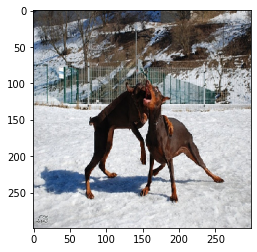

In [32]:
img = load_img("data/Flicker8k_Dataset/3385593926_d3e9c21170.jpg",target_size=(299,299))
plt.imshow(img)

In [27]:
predict_caption(test1)

'dog be run through the snow'